In [1]:
import os

from qcodes import Station, load_or_create_experiment
from qcodes.dataset.plotting import plot_dataset
from qcodes.dataset.data_set import load_by_run_spec
 
import nanotune as nt
from nanotune.tuningstages.gatecharacterization1d import GateCharacterization1D
from nanotune.classification.classifier import Classifier

from sim.data_providers import QcodesDataProvider
from sim.qcodes_mocks import QuantumDotMockInstrument

nt_path = os.path.dirname(os.path.dirname(os.path.abspath(nt.__file__)))

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /Users/jana/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /Users/jana/.qcodes/logs/210528-91825-qcodes.log


Define databases

In [2]:
db_name_original_data = "device_characterization.db"
db_folder_original_data = os.path.join(nt_path, "data", "tuning")
char_db_path = os.path.join(db_folder_original_data, db_name_original_data)
nt.set_database(db_name_original_data, db_folder_original_data)

db_name_replay = 'qdsim_test.db'
db_folder_replay = os.getcwd()

Create qc.Station

In [3]:
station = Station()

qd_mock_instrument = QuantumDotMockInstrument()
station.add_component(qd_mock_instrument, name="qdmock")

qdsim = qd_mock_instrument.mock_device

 Create the data provider to use for the right plunger pinch-off measurement. 
 Binding the sim.r_plunger pin as the input data provider.

In [4]:
experiment = "GB_Newtown_Dev_3_2"
captured_run_id = 1206

# load original dataset to get device normalization constant
ds = nt.Dataset(1206, db_name_original_data, db_folder_original_data)

pinchoff_right_plunger = QcodesDataProvider(
    [qdsim.r_plunger], 
    char_db_path, 
    "GB_Newtown_Dev_3_2", 
    captured_run_id,
)
qd_mock_instrument.drain.set_data_provider(pinchoff_right_plunger)

Train pinchoff classifier

In [5]:
pinchoff_classifier = Classifier(
    ['pinchoff.npy'],
    'pinchoff',
    data_types=["signal"],
    classifier="SVC",
    folder_path=os.path.join(nt_path, 'data', 'training_data'),
)
pinchoff_classifier.train()

/Users/jana/Documents/code/nanotune/nanotune/data/training_data/pinchoff.npy
n_samples: 3699


Instantiate nanotune GateCharacterization1D tuning stage

In [6]:
nt.set_database(db_name_replay, db_folder_replay)
exp = load_or_create_experiment("simtest")

In [7]:
gatech = GateCharacterization1D(
    data_settings={
        'db_name': db_name_replay,
        'db_folder': db_folder_replay,
        'normalization_constants': ds.normalization_constants,
    },
    setpoint_settings={
        'voltage_precision': 0.01,
        'parameters_to_sweep': [qd_mock_instrument.right_plunger],
        'safety_voltage_ranges': [(-3, 0)],
        'current_valid_ranges': [(-1, 0)],
    },
    readout_methods={'dc_current': qd_mock_instrument.drain},
    classifier=pinchoff_classifier,
    voltage_interval_to_track=0.3,
)

Run gate characterization stage

2021-05-28 15:14:28,846 ¦ nanotune.data.dataset ¦ WARNING ¦ dataset ¦ _normalize_data ¦ 237 ¦ ('Dataset 48: ', 'Wrong normalization constant')


Starting experimental run with id: 48. 


2021-05-28 15:14:28,937 ¦ nanotune.data.dataset ¦ WARNING ¦ dataset ¦ _normalize_data ¦ 237 ¦ ('Dataset 48: ', 'Wrong normalization constant')
2021-05-28 15:14:28,990 ¦ nanotune.data.dataset ¦ WARNING ¦ dataset ¦ _normalize_data ¦ 237 ¦ ('Dataset 48: ', 'Wrong normalization constant')
2021-05-28 15:14:29,108 ¦ nanotune.data.dataset ¦ WARNING ¦ dataset ¦ _normalize_data ¦ 237 ¦ ('Dataset 48: ', 'Wrong normalization constant')


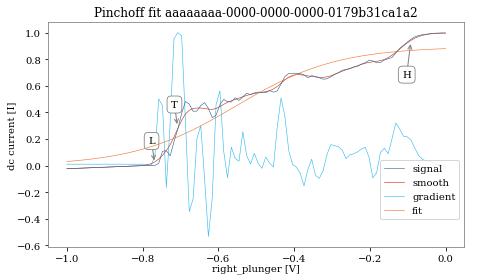

gatecharacterization1d: Good result measured. Regime: pinchoff. Termination reasons: None. 


In [8]:
tuning_result = gatech.run_stage()

In [9]:
tuning_result.success

True

In [10]:
tuning_result.ml_result

{'features': {'dc_current': {'amplitude': 0.44680549833037975,
   'slope': 3.718456967075545,
   'offset': -1.6571432756856845,
   'residuals': 0.13731377761105742,
   'low_voltage': -0.767676767676768,
   'high_voltage': -0.0909090909090909,
   'low_signal': 0.028513701692976824,
   'high_signal': 0.9423166096088986,
   'transition_voltage': -0.707070707070707,
   'transition_signal': 0.2791761004636656,
   'max_signal': 0.9972517232633776,
   'min_signal': -0.023107398869144757}},
 'quality': True,
 'regime': 'pinchoff'}

In [11]:
tuning_result.data_ids

[48]